In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-payment-fraud-detection/onlinefraud.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, recall_score, f1_score

import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("/kaggle/input/online-payment-fraud-detection/onlinefraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
df = df.iloc[:,:-1]

obj = (df.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (df.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (df.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))

Categorical variables: 3
Integer variables: 2
Float variables: 5


<Axes: xlabel='type', ylabel='count'>

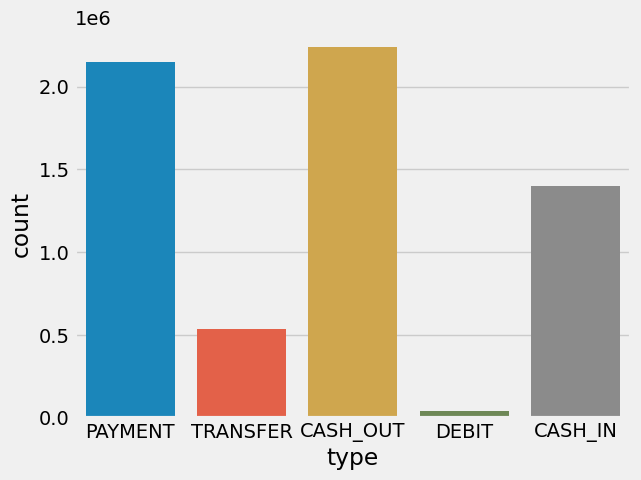

In [7]:
sns.countplot(x='type', data=df)

<Axes: xlabel='type', ylabel='amount'>

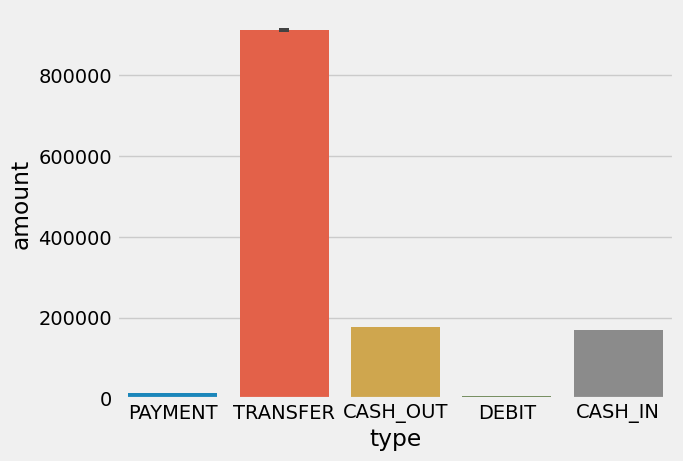

In [8]:
sns.barplot(x='type', y='amount', data=df)

In [9]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: xlabel='step', ylabel='Density'>

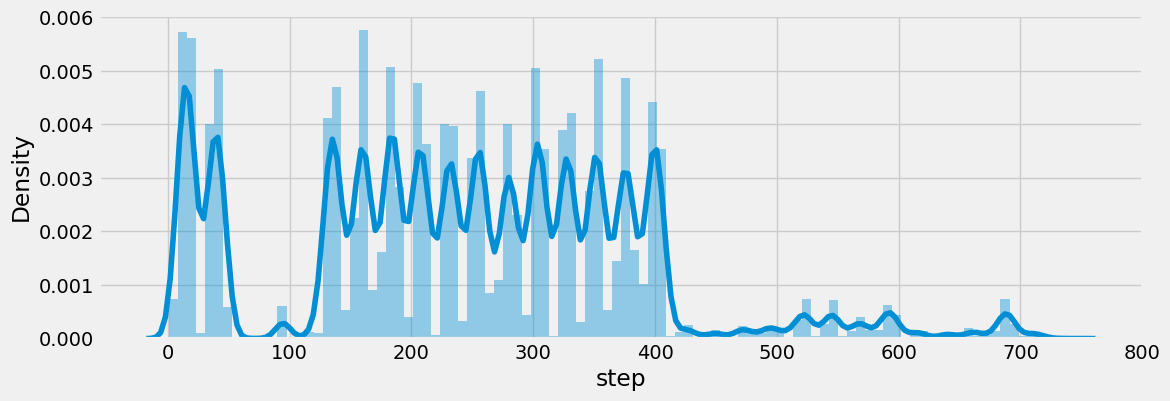

In [10]:
plt.figure(figsize=(12, 4))
sns.distplot(df['step'], bins=100)

<Axes: >

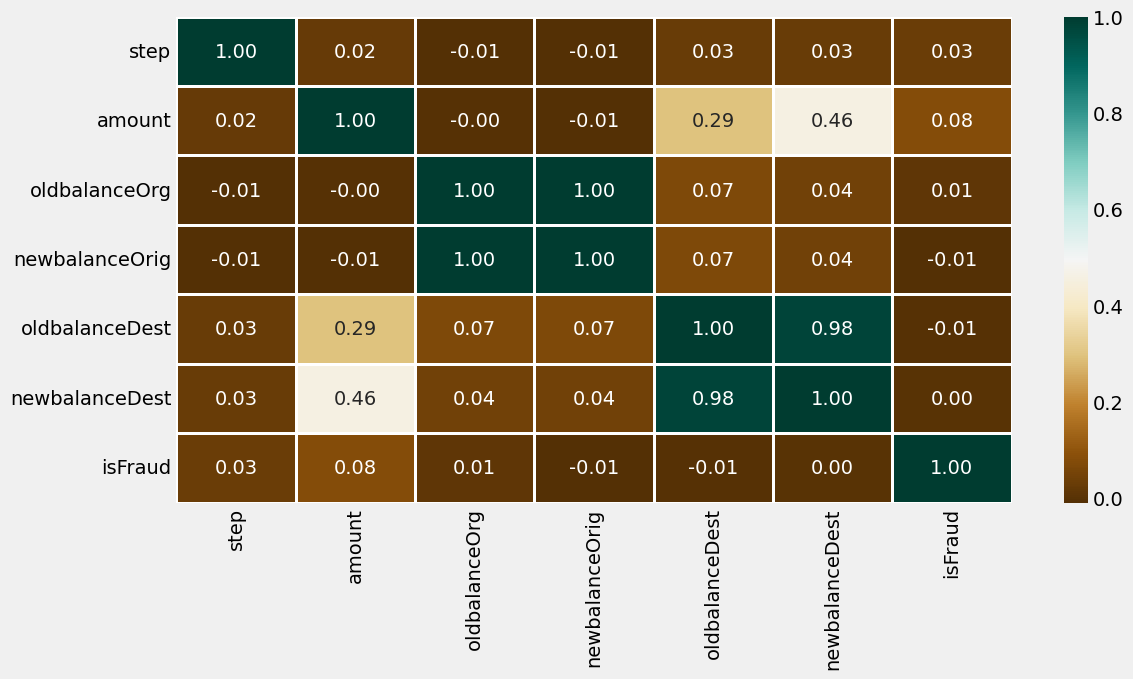

In [11]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_df.corr(), cmap='BrBG', fmt='.2f', linewidths=2, annot=True)

In [12]:
type_new = pd.get_dummies(df['type'], drop_first=True)
df_new = pd.concat([df, type_new], axis=1)
df_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,False,False,True,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,False,False,True,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,False,False,False,True
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,True,False,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,False,False,True,False


In [13]:
X = df_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = df_new['isFraud']
X.shape, y.shape

((6362620, 10), (6362620,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

XGB.score(X_train,y_train)

0.9998841447615695

In [16]:
XGB.score(X_test,y_test)

0.9998061595170962

In [17]:
LR = LogisticRegression()
LR.fit(X_train,y_train)

LR.score(X_train,y_train)

0.9982801334760119

In [18]:
LR.score(X_test,y_test)

0.9983256373422689

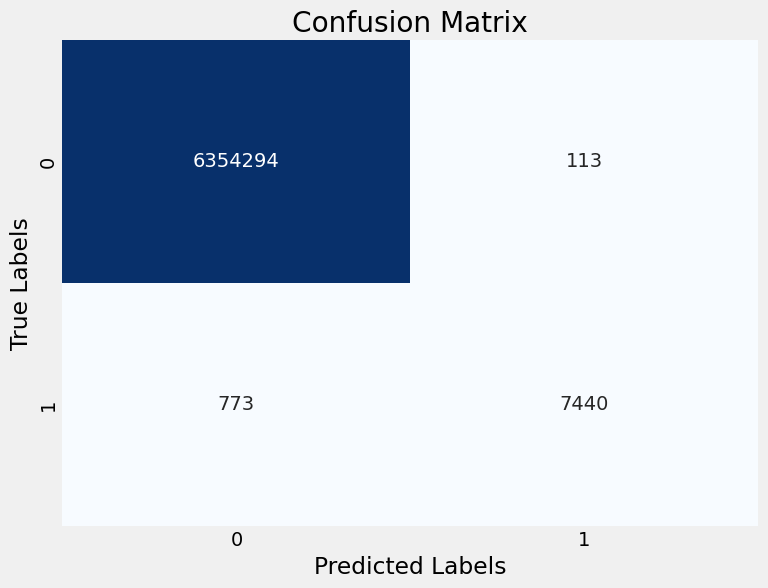

In [19]:
y_pred = XGB.predict(X)

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
recall = recall_score(y, y_pred)
recall

0.905880920491903

In [21]:
f1 = f1_score(y, y_pred)
f1

0.9438031206393505